In [1]:
#いろいろインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [2]:

# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]

 # 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1
!pip install pystan~=2.14
!pip install plotly


# matplotlib日本語化対応
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 38.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61975567 sha256=d820d560d8e5db2dd054f53742450d5909eb0427d037fcabc9f287c5d1ab1f78
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan


In [3]:
years = [2021, 2022, 2023]
df = pd.DataFrame()
for year in years:
    _df = pd.read_csv(f"https://www.tepco.co.jp/forecast/html/images/juyo-{year}.csv", encoding="shift-jis", skiprows=1)
    df = pd.concat([df, _df], axis=0)

In [4]:
#データの前処理
df = df.reset_index(drop=True)
date = df["DATE"][0]
time = df["TIME"][0]
str_datetime = f"{date} {time}"
str_datetime
from datetime import datetime as dt
datetime = dt.strptime(str_datetime, "%Y/%m/%d %H:%M")
datetime

datetime.datetime(2021, 1, 1, 0, 0)

In [5]:
datatimes = []
for index, datum in df.iterrows():
    date = datum["DATE"]
    time = datum["TIME"]
    str_datetime = f"{date} {time}"
    datatime = dt.strptime(str_datetime, "%Y/%m/%d %H:%M")
    datatimes.append(datatime)

In [6]:
df["ds"] = datatimes

In [7]:
date_time = df["ds"]
print(date_time)
print(len(date_time))
data = df["実績(万kW)"]
data = data.values
print(data)
print(type(data))

0       2021-01-01 00:00:00
1       2021-01-01 01:00:00
2       2021-01-01 02:00:00
3       2021-01-01 03:00:00
4       2021-01-01 04:00:00
                ...        
26275   2023-12-31 19:00:00
26276   2023-12-31 20:00:00
26277   2023-12-31 21:00:00
26278   2023-12-31 22:00:00
26279   2023-12-31 23:00:00
Name: ds, Length: 26280, dtype: datetime64[ns]
26280
[3184 2978 2834 ... 2754 2647 2583]
<class 'numpy.ndarray'>


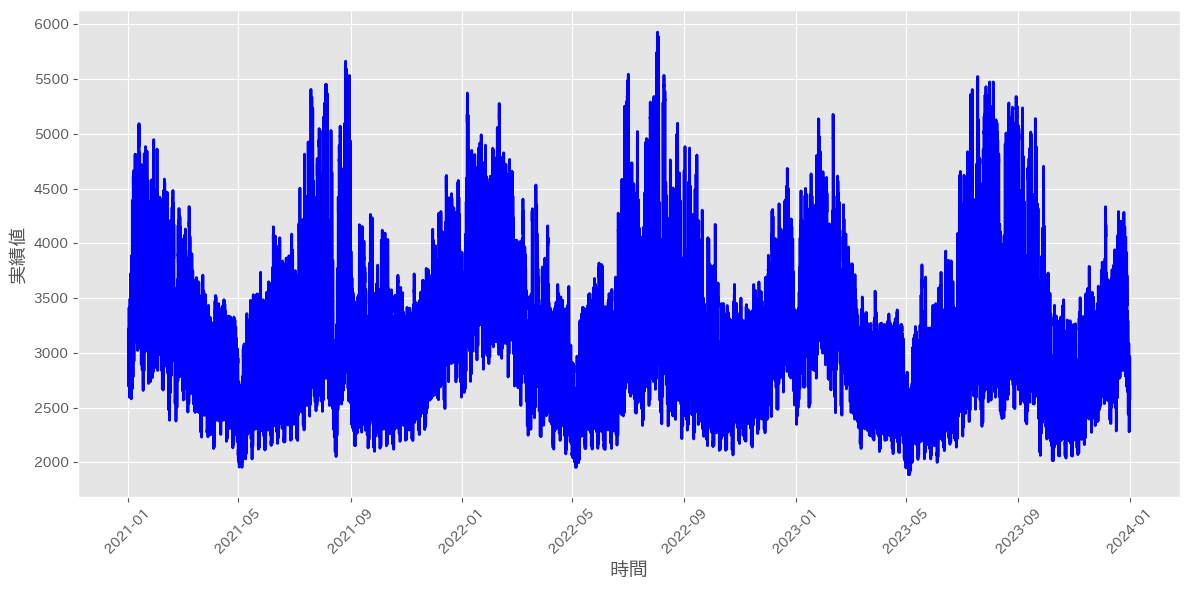

In [8]:
# 折れ線グラフを描画
plt.plot(date_time, data, color='b', linestyle='-', linewidth=2, markersize=8)
#plt.xticks(np.arange(0, 26310, step=24))
plt.xlabel('時間', fontsize=14)
plt.ylabel('実績値', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

In [9]:
#0〜1にスケーリング
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(data)
df_scale = pd.DataFrame(scaler.fit_transform(data),index = data.index,columns=data.columns)


In [10]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータを分ける
train_data, test_data = train_test_split(df_scale, test_size=0.2, shuffle=False)

print("学習データ:")
print(train_data)
print("\nテストデータ:")
print(test_data)



学習データ:
              0
0      0.320633
1      0.269668
2      0.234043
3      0.211529
4      0.200148
...         ...
21019  0.268926
21020  0.239485
21021  0.202622
21022  0.174419
21023  0.143246

[21024 rows x 1 columns]

テストデータ:
              0
21024  0.098961
21025  0.071004
21026  0.067788
21027  0.076200
21028  0.073973
...         ...
26275  0.255072
26276  0.236764
26277  0.214250
26278  0.187778
26279  0.171945

[5256 rows x 1 columns]


In [11]:
look_back = 24 #どれくらい過去まで見るか

def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)


モデルの定義

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error


#モデルの定義
model = Sequential()
x = model.add(LSTM(125, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100))
model.add(Activation("relu"))
model.add(Dense(1)) # 出力次元数は1
optimizer = Adam(learning_rate=0.001)

#コンパイル
model.compile(loss='mean_squared_error', optimizer=optimizer)



In [13]:
history = model.fit(X_train, y_train, epochs=15, batch_size=1)

Epoch 1/15
21000/21000 [==============================] - 654s 31ms/step - loss: 0.0010
Epoch 2/15
21000/21000 [==============================] - 610s 29ms/step - loss: 2.8913e-04
Epoch 3/15
21000/21000 [==============================] - 619s 29ms/step - loss: 2.2373e-04
Epoch 4/15
21000/21000 [==============================] - 602s 29ms/step - loss: 1.8792e-04
Epoch 5/15
21000/21000 [==============================] - 599s 29ms/step - loss: 1.7469e-04
Epoch 6/15
21000/21000 [==============================] - 592s 28ms/step - loss: 1.5925e-04
Epoch 7/15
21000/21000 [==============================] - 596s 28ms/step - loss: 1.4586e-04
Epoch 8/15
21000/21000 [==============================] - 594s 28ms/step - loss: 1.3791e-04
Epoch 9/15
21000/21000 [==============================] - 608s 29ms/step - loss: 1.2893e-04
Epoch 10/15
21000/21000 [==============================] - 611s 29ms/step - loss: 1.2382e-04
Epoch 11/15
21000/21000 [==============================] - 605s 29ms/step - loss: 1

精度の確認

In [14]:
model.evaluate(X_test,y_test,batch_size=1)

5232/5232 [==============================] - 64s 12ms/step - loss: 8.4642e-05


8.464154234388843e-05

In [15]:
from sklearn.metrics import mean_absolute_percentage_error
y_test = scaler.inverse_transform(test_data[:-24])

y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

164/164 [==============================] - 4s 21ms/step
テストデータに対するMAPE: 0.06316221253491772


学習曲線の確認

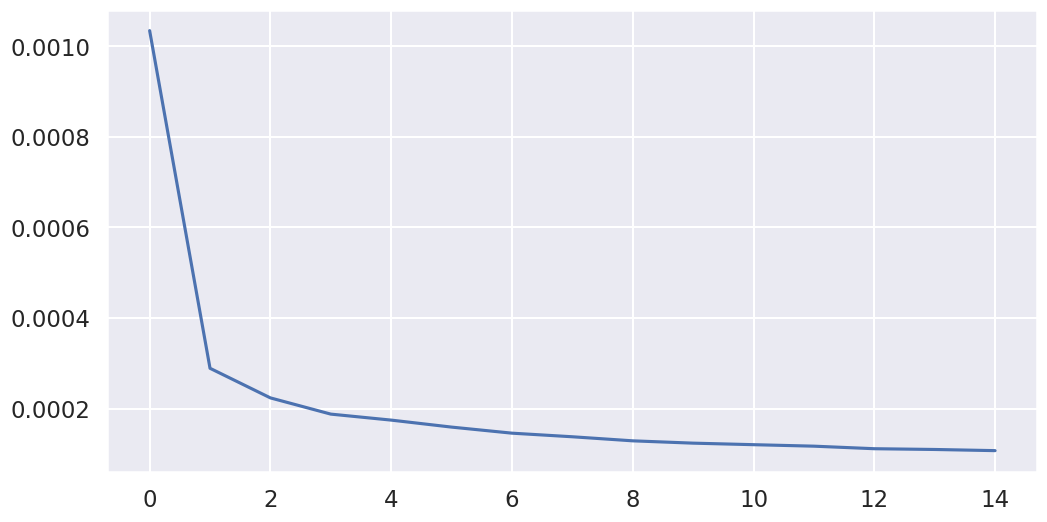

In [16]:
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])

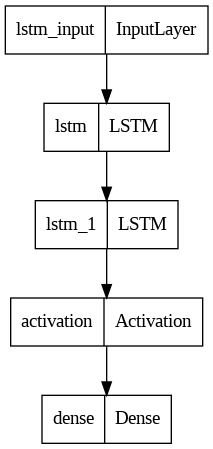

In [17]:
from keras.utils import plot_model

# モデルの図表を作成
plot_model(model)

予測

164/164 [==============================] - 5s 31ms/step


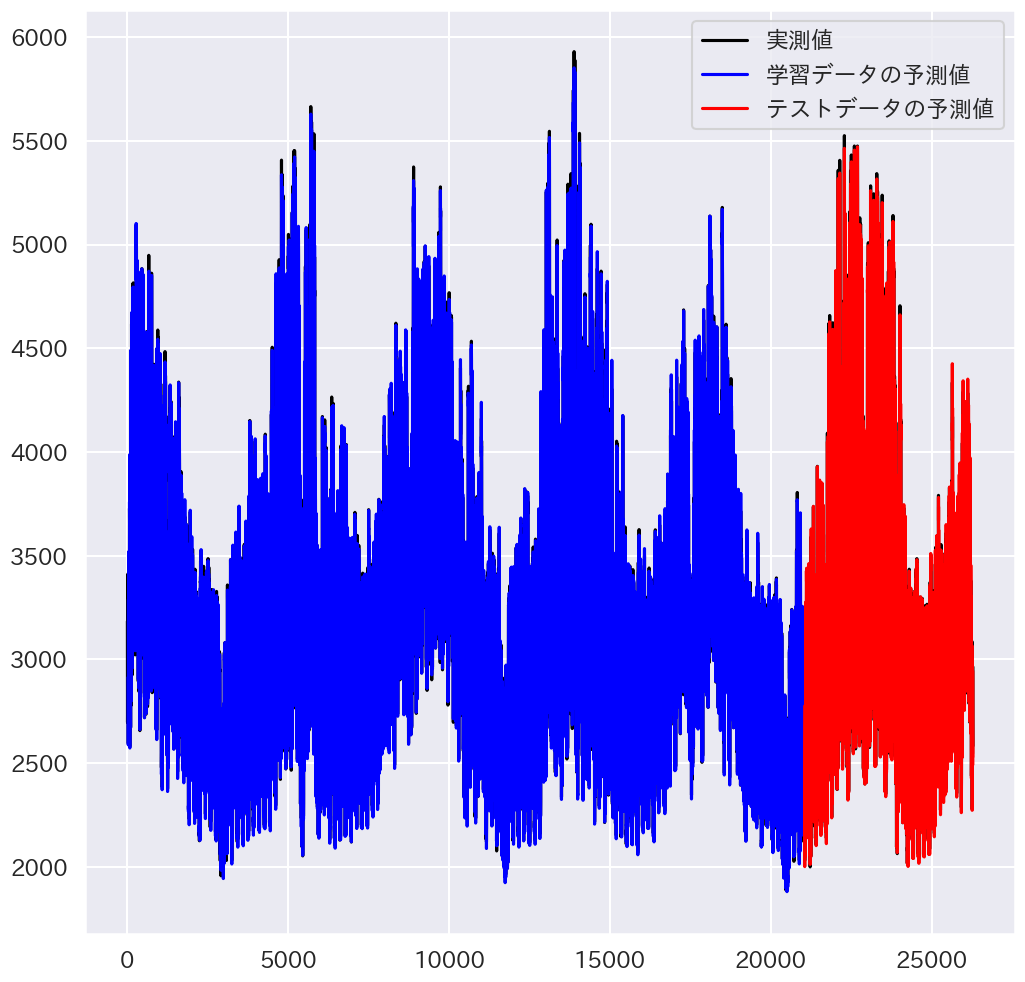

In [18]:

import matplotlib.pyplot as plt
import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

# ラベルを右上に配置
plt.legend(loc='upper left')

plt.legend()


164/164 [==============================] - 5s 31ms/step


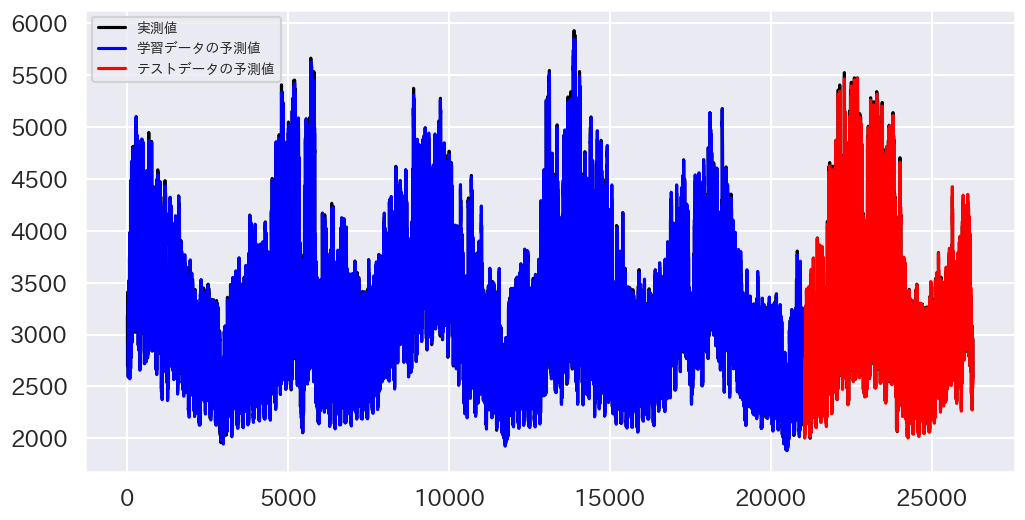

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズとフォントサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index, columns=data.columns)
plt.plot(df_month, color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:], columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:], columns=test_data.columns)
plt.plot(df_month_test_pred, color="red", label="テストデータの予測値")


# グラフ内のラベルを右上に配置
plt.legend(loc='upper left', fontsize=10)

# グラフ表示
plt.show()


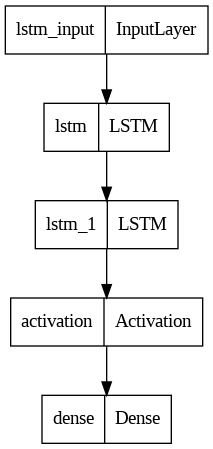

In [20]:
from keras.utils import plot_model

# モデルの図表を作成
plot_model(model)

Epoch 1/15
21012/21012 [==============================] - 435s 21ms/step - loss: 0.0010
Epoch 2/15
21012/21012 [==============================] - 433s 21ms/step - loss: 3.2288e-04
Epoch 3/15
21012/21012 [==============================] - 435s 21ms/step - loss: 2.5204e-04
Epoch 4/15
21012/21012 [==============================] - 397s 19ms/step - loss: 2.1622e-04
Epoch 5/15
21012/21012 [==============================] - 382s 18ms/step - loss: 2.0124e-04
Epoch 6/15
21012/21012 [==============================] - 432s 21ms/step - loss: 1.9016e-04
Epoch 7/15
21012/21012 [==============================] - 434s 21ms/step - loss: 1.7699e-04
Epoch 8/15
21012/21012 [==============================] - 434s 21ms/step - loss: 1.6186e-04
Epoch 9/15
21012/21012 [==============================] - 445s 21ms/step - loss: 1.5621e-04
Epoch 10/15
21012/21012 [==============================] - 436s 21ms/step - loss: 1.5098e-04
Epoch 11/15
21012/21012 [==============================] - 438s 21ms/step - loss: 1

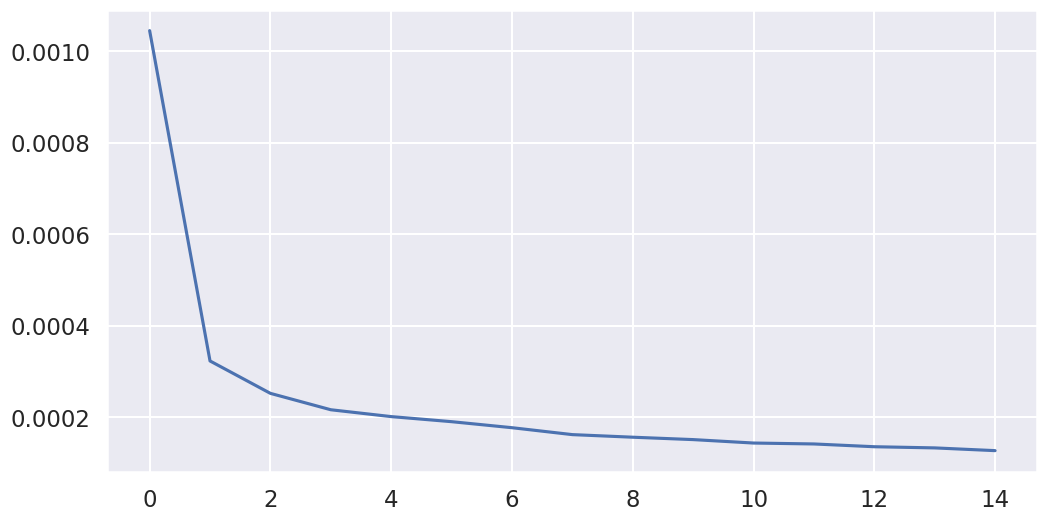

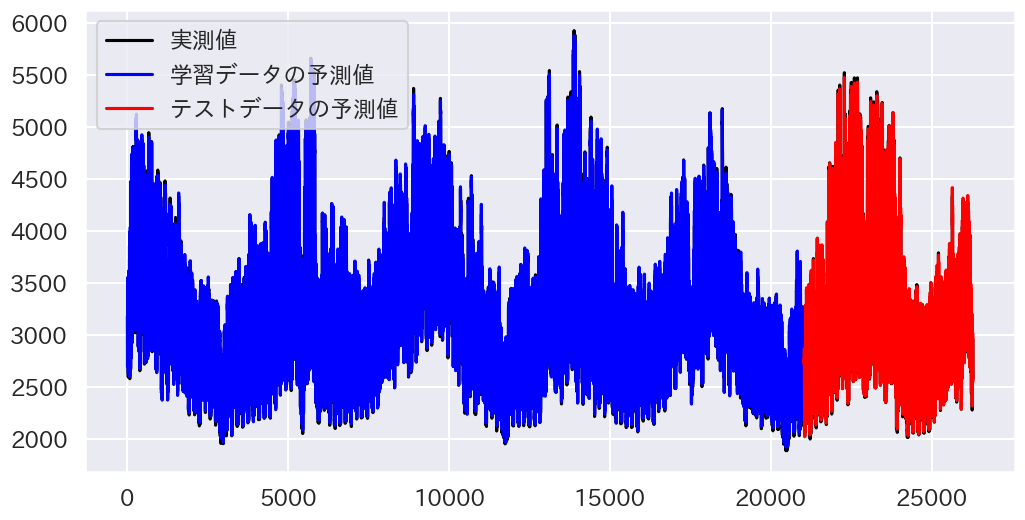

In [21]:
look_back = 12 #どれくらい過去まで見るか

def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)





model = Sequential()
x = model.add(LSTM(125, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100))
model.add(Activation("relu"))
model.add(Dense(len(data.columns))) #出力層はデータ数に合わせる
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=15, batch_size=1)

#精度の確認
model.evaluate(X_test,y_test,batch_size=1)
y_test = scaler.inverse_transform(test_data[:-12])

y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])



import matplotlib.pyplot as plt
import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

plt.legend()


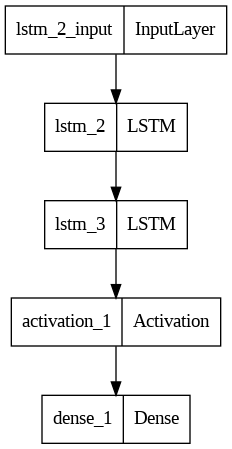

In [22]:
from keras.utils import plot_model

# モデルの図表を作成
plot_model(model)